In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.dates as mdates

In [24]:
# Load data
station_51 = pd.read_csv("../data/raw/LabSTAF/labstaf_csv_data_51.csv")
station_130 = pd.read_csv("../data/raw/LabSTAF/labstaf_csv_data_130.csv")
metadata = pd.read_csv("../data/samples_env.csv")

# Convert date to datetime format
metadata["Date"] = pd.to_datetime(metadata["Date"])
colnames = ["Station", "Alpha", "Beta", "Ek", "EkBeta", "rPm",
            "JVPIIm", "GOPIIm", "Fo", "Fm", "Fv", "Fv_Fm", "Fv_Fmc",
            "F_prime", "Fm_prime", "Fq_prime", "Fq_Fm_prime",
            "Fq_Fmc_prime", "NPQ", "NSV", "PP"]
station_51.columns = colnames
station_130.columns = colnames

# Merge metadata (to get day_moment information)
station_51 = station_51.merge(metadata, on="Station", how="left")
station_130 = station_130.merge(metadata, on="Station", how="left")

# Define photosynthesis-related parameters to adjust at night
photosynthesis_params = ["JVPIIm", "GOPIIm", "PP"]

# Set photosynthesis-related parameters to zero during 'Night'
for param in photosynthesis_params:
    station_51.loc[station_51["day_moment"] == "Night", param] = 0
    station_130.loc[station_130["day_moment"] == "Night", param] = 0

# Remove extreme negative values
for param in photosynthesis_params:
    station_51 = station_51[station_51[param] > -1000]
    station_130 = station_130[station_130[param] > -1000]


In [49]:
# Define color scheme for light phases
light_colors = {
    "Night": "black",
    "Astronomical twilight": "darkblue",
    "Nautical twilight": "blue",
    "Civil twilight": "lightblue",
    "Day": "lightyellow"
}

# Output directory for figures
output_dir = "../figures/FRRF/"
os.makedirs(output_dir, exist_ok=True)

# Function to apply LOWESS smoothing for regression trend line
def lowess_smoothing(x, y, frac=0.5):
    y_filtered = y.dropna()
    x_filtered = x[y.notna()].astype("int64")  # Keep only valid values
    smoothed = sm.nonparametric.lowess(y_filtered, x_filtered, frac=frac, return_sorted=True)
    return pd.DataFrame({"Date": pd.to_datetime(smoothed[:, 0]), "Smoothed": smoothed[:, 1]})

# Function to plot parameter with shading
def plot_parameter(station_51, station_130, parameter, y_label):
    fig, axes = plt.subplots(1, 2, sharey=True)

    # Left panel (Station 51)
    ax = axes[0]
    for phase, group in station_51.groupby("day_moment"):
        ax.axvspan(group["Date"].min(), group["Date"].max(), color=light_colors.get(phase, "gray"), alpha=0.2)
    
    sns.scatterplot(data=station_51, x="Date", y=parameter, ax=ax, color="black", alpha=0.6, s=20, label="Data")
    smoothed_51 = lowess_smoothing(station_51["Date"], station_51[parameter])
    sns.lineplot(data=smoothed_51, x="Date", y="Smoothed", ax=ax, color="red", label="Smoothed Regression", lw=2)
    
    ax.set_title(f"Station 51")
    ax.set_ylabel(y_label)
    ax.set_xlabel("Date")
    # Formatting the x-axis to show day and month
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    # Showing time every 4 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    # Rotating and showing the x-axis labels
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    
    ax.get_legend().remove()
    
    # Right panel (Station 130)
    ax = axes[1]
    for phase, group in station_130.groupby("day_moment"):
        ax.axvspan(group["Date"].min(), group["Date"].max(), color=light_colors.get(phase, "gray"), alpha=0.2)
    
    sns.scatterplot(data=station_130, x="Date", y=parameter, ax=ax, color="black", alpha=0.6, s=20, label="Data")
    smoothed_130 = lowess_smoothing(station_130["Date"], station_130[parameter])
    sns.lineplot(data=smoothed_130, x="Date", y="Smoothed", ax=ax, color="red", label="Smoothed Regression", lw=2)
    
    ax.set_title(f"Station 130")
    ax.set_ylabel("")
    ax.set_xlabel("Date")
    
    # Formatting the x-axis to show day and month
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    # Showing time every 4 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    # Rotating and showing the x-axis labels
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)
    
    ax.get_legend().remove()

    plt.tight_layout()
    
    # set size of figure
    fig.set_size_inches(6, 3)

    # Save as high-quality SVG
    plot_filename = os.path.join(output_dir, f"{parameter}_Multipanel.svg")
    plt.savefig(plot_filename, format="svg", dpi=600)
    plot_filename = os.path.join(output_dir, f"{parameter}_Multipanel.png")
    plt.savefig(plot_filename, format="png", dpi=600)
    plt.show()

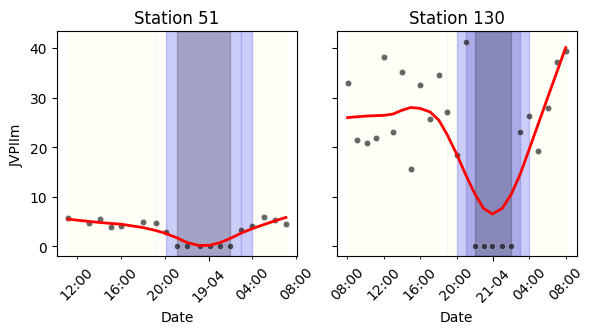

In [50]:
plot_parameter(station_51, station_130, "JVPIIm", "JVPIIm")

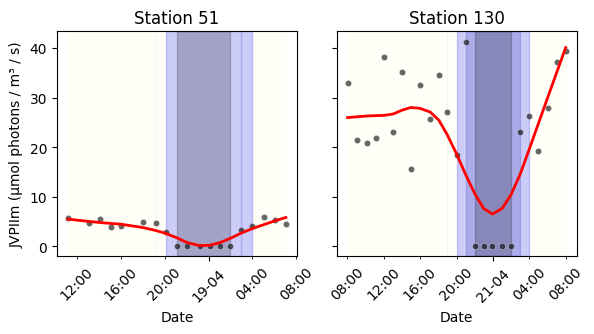

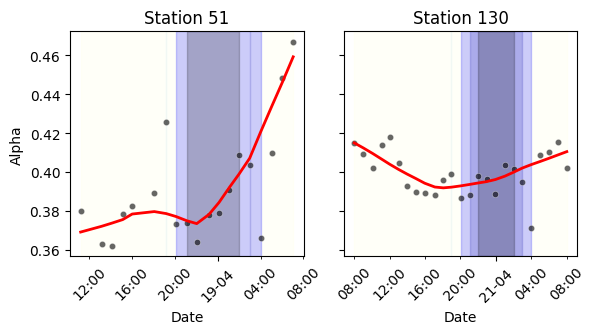

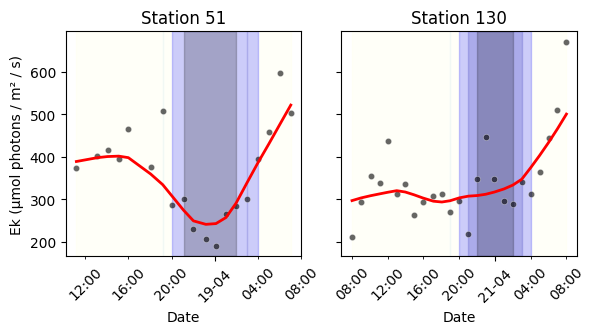

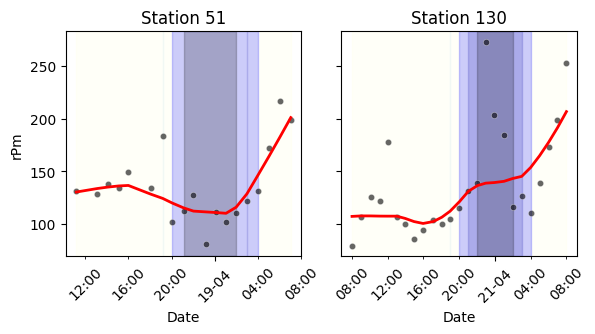

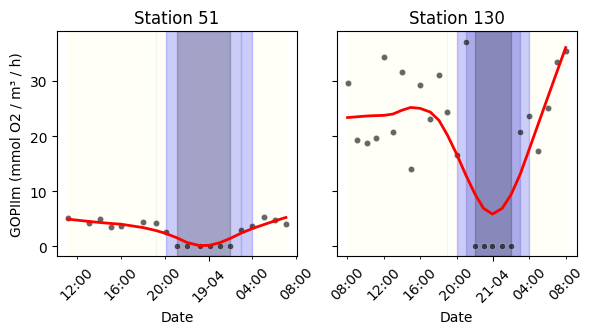

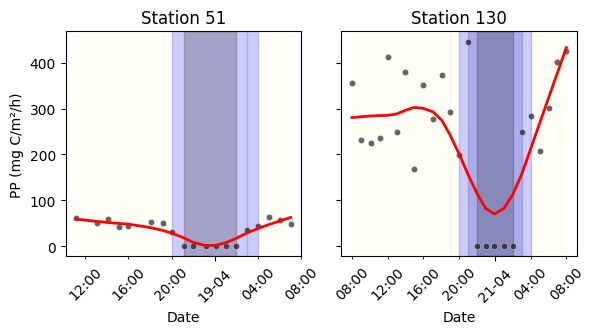

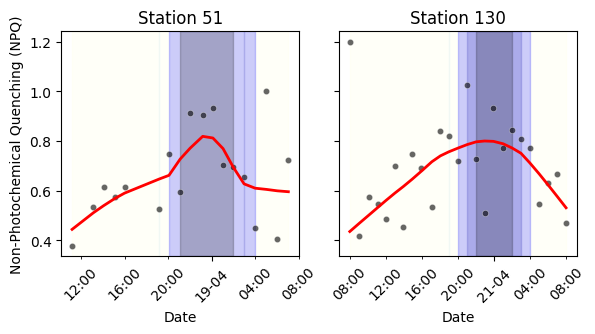

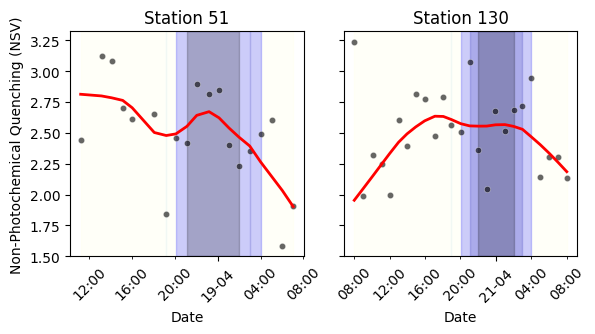

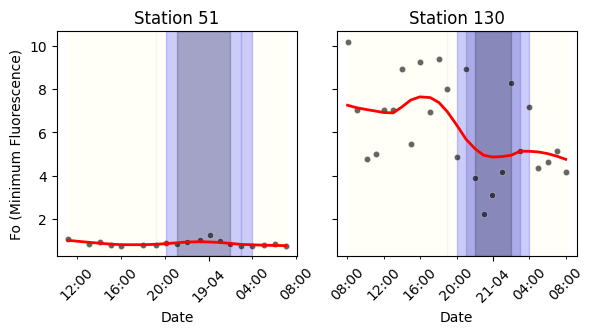

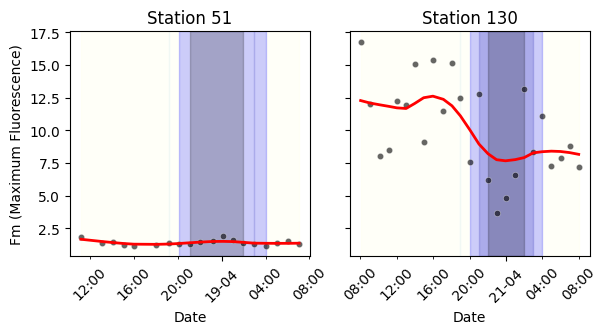

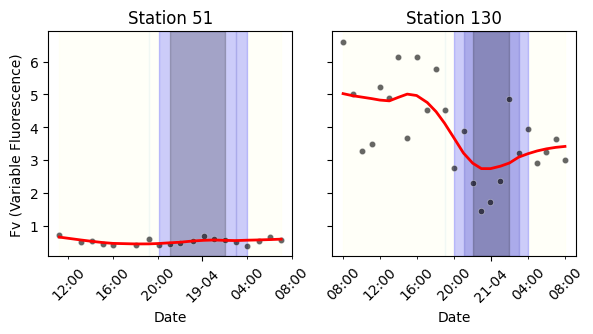

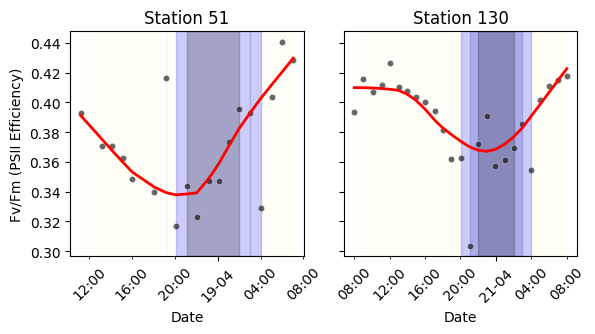

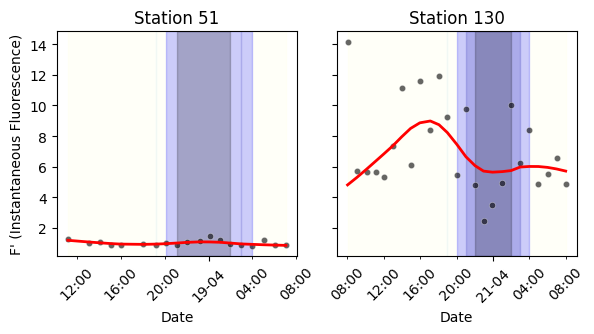

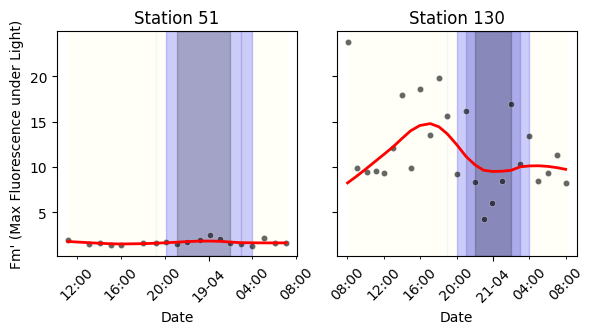

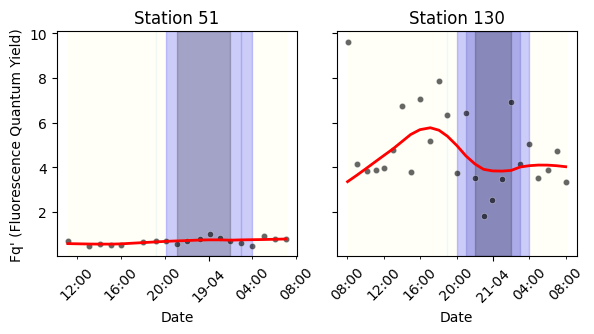

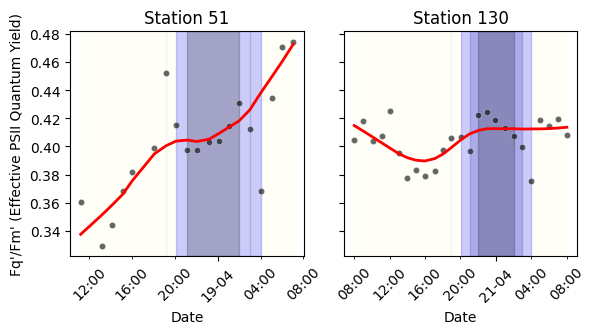

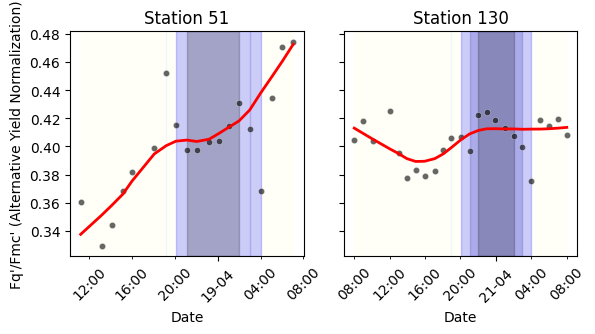

In [45]:
# Define biological parameters and their corresponding labels
parameters = [
    ("JVPIIm", "JVPIIm (µmol photons / m³ / s)"),
    ("Alpha", "Alpha"),
    ("Ek", "Ek (µmol photons / m² / s)"),
    ("rPm", "rPm"),
    ("GOPIIm", "GOPIIm (mmol O2 / m³ / h)"),
    ("PP", "PP (mg C/m²/h)"),
    ("NPQ", "Non-Photochemical Quenching (NPQ)"),
    ("NSV", "Non-Photochemical Quenching (NSV)"),
    ("Fo", "Fo (Minimum Fluorescence)"),
    ("Fm", "Fm (Maximum Fluorescence)"),
    ("Fv", "Fv (Variable Fluorescence)"),
    ("Fv_Fm", "Fv/Fm (PSII Efficiency)"),
    ("F_prime", "F' (Instantaneous Fluorescence)"),
    ("Fm_prime", "Fm' (Max Fluorescence under Light)"),
    ("Fq_prime", "Fq' (Fluorescence Quantum Yield)"),
    ("Fq_Fm_prime", "Fq'/Fm' (Effective PSII Quantum Yield)"),
    ("Fq_Fmc_prime", "Fq'/Fmc' (Alternative Yield Normalization)")
]

# Generate plots for all parameters
for param, label in parameters:
    plot_parameter(station_51, station_130, param, label)